In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.signal import firwin, butter, lfilter # no MatLab: fir1, butter, filter
#matplotlib inline
#import mpld3
from copy import deepcopy
from scipy.interpolate import interp1d
import math
import pandas as pd
#mpld3.enable_notebook()

## Criando as funções de extração dos picos QRS e os filtros que podem ser aplicados
 * Ao utilizar bandas de frequência de mais ou menos 8-25 Hz conseguimos evidenciar melhor os picos QRS, melhorando a detecção. De fato, a utilização do filtro passa-faixa e dentro deste intervalo de frequências foi o que teve melhores resultados.
 * Aqui, vamos utilizar o filtro do tipo Hamming e alterar os parâmetros para melhor identificação do complexo QRS.
 * A utilização das derivadas permitiu achar com boa precisão os picos R e S, mas o pico Q provavelmente possui um valor de derivada intermediário entre a mínima e a máxima que não foi possível encontrar (mesmo alterando as bandas de frequência do sinal), portanto o sinal está com a deteção do pico Q incorreta.

In [2]:
def deteccao_picos_r(x, type_filter = 'notch', freqs_notch = [50, 150], freq_harmonico_superior = 40, fs = 500, freq_linha_base = 0.6, freqs_qrs = [8, 25], duracao_minima_deteccao_r = 0.025, tipo_filtro = 'hamming', ordem_filtro = 0, amostras_busca_S = 20):
    if ordem_filtro == 0:
        if tipo_filtro in ('hamming', 'hann', 'blackman', 'retangular'):
            ordem_filtro = 1000
        else:
            ordem_filtro = 5
    y = x
    if type_filter == 'notch':
        for n in range(0, len(freqs_notch)):
            y = notch(y, tipo_filtro, ordem_filtro, freqs_notch[n], fs)

    if type_filter == 'lowpass':
        y = passa_baixas(y, tipo_filtro, ordem_filtro, freq_harmonico_superior, fs)

    if type_filter == 'highpass':
        y = passa_altas(y, tipo_filtro, ordem_filtro, freq_linha_base, fs)

    if type_filter == 'bandpass':
        y = passa_faixa(y, tipo_filtro, ordem_filtro, np.array(freqs_qrs), fs)
        
    y = y[1 : ] - y[: len(y) - 1]
    M = np.max(np.abs(y))
    k = np.where(np.abs(y) > 0.6 * M)[0]
    sign_y = np.sign(y[k])
    mudanca_sinal_derivada = sign_y[0 : len(sign_y) - 1] - sign_y[1 : ]
    k2 = np.where(mudanca_sinal_derivada == 2)[0]
    k2 = k[k2]
    k3 = np.where(mudanca_sinal_derivada == -2)[0]
    k3 = k[k3]
    k2b = deepcopy(k2)
    k3b = deepcopy(k3)
    for i in range(0, len(k2)):
        found = False
        n = 0
        while n < len(k) and not(found):
            n += 1
            if k[n] > k2[i]:
                found = True
        if found:
            k2b[i] = int(k[n])
    for i in range(0, len(k2)):
        y_ = np.abs(y[k2[i] : k2b[i]])
        k2[i] = np.argmin(y_) + k2[i]
        
    k2 = k2 + 1
    k3 = deepcopy(k2)
    
    for i in range(0, len(k3)):
        janela_busca_S = np.abs(y[k3[i] : k3[i] + amostras_busca_S])
        k3[i] = np.argmin(janela_busca_S) + k3[i]
        
    k4 = deepcopy(k2)
    janela_busca_Q = 45
    
    # k2 = R
    # k3 = S
    # k4 = Q
    
    for i in range(len(k4)):
        start_index = max(0, k4[i] - janela_busca_Q)
        end_index = k4[i]

        window_derivative = np.abs(y[start_index:end_index])

        min_derivative_index = np.argmin(window_derivative)

        x_data = np.arange(start_index, end_index)
        y_data = y[start_index:end_index]
        interp_func = interp1d(x_data, y_data, kind='cubic')

        fine_tuning_range = np.linspace(x_data[0], x_data[-1], num=100)
        fine_tuned_values = interp_func(fine_tuning_range)

        fine_tuning_min_index = np.argmin(np.abs(fine_tuned_values))

        k4[i] = fine_tuning_range[fine_tuning_min_index]
    
    return y, k, k2, k3, k4

def notch(x, tipo_filtro, ordem_filtro, freq, fs):
    """
    Remove frequências específicas de um sinal.
    """
    if tipo_filtro in ('hamming', 'hann', 'blackman', 'retangular'):
        banda_rejeicao = np.array([freq - 5, freq + 5])
        h = firwin(ordem_filtro + 1, banda_rejeicao / fs * 2, \
        window = tipo_filtro, pass_zero = 'bandstop')
        y = np.convolve(h, x, 'same')
    if tipo_filtro == 'butter':
        num, den = butter(ordem_filtro, banda_rejeicao / fs * 2, btype = 'bandstop')
        # num, den = iirnotch(freq, 10, fs)
        y = lfilter(num, den, x)
    return y

def passa_baixas(x, tipo_filtro, ordem_filtro, freq, fs):
    """
    Permite a passagem de sinais com frequências abaixo de uma determinada frequência de corte e atnua valores acima desse valor.
    """
    if tipo_filtro in ('hamming', 'hann', 'blackman', 'retangular'):
        h = firwin(ordem_filtro + 1, freq / fs * 2, \
        window = tipo_filtro, pass_zero = 'lowpass')
        y = np.convolve(h, x, 'same')
    if tipo_filtro == 'butter':
        num, den = butter(ordem_filtro, freq / fs * 2, btype = 'lowpass')
        y = lfilter(num, den, x)
    return y

def passa_altas(x, tipo_filtro, ordem_filtro, freq, fs):
    """
    Permite a passagem de sinais com frequências acima de uma determinada frequência de corte, enquanto atenua as frequências abaixo desse valor.
    """
    if tipo_filtro in ('hamming', 'hann', 'blackman', 'retangular'):
        h = firwin(ordem_filtro + 1, freq / fs * 2, \
        window = tipo_filtro, pass_zero = 'highpass')
        y = np.convolve(h, x, 'same')
    if tipo_filtro == 'butter':
        num, den = butter(ordem_filtro, freq / fs * 2, btype = 'highpass')
        y = lfilter(num, den, x)
    return y

def passa_faixa(x, tipo_filtro, ordem_filtro, banda_passante, fs):
    """
    Permite a passagem de sinais em uma determinada faixa de frequência, enquanto atenua as frequências abaixo e acima dessa faixa.
    """
    if tipo_filtro in ('hamming', 'hann', 'blackman', 'retangular'):
        h = firwin(ordem_filtro + 1, banda_passante / fs * 2, \
        window = tipo_filtro, pass_zero = 'bandpass')
        y = np.convolve(h, x, 'same')
    if tipo_filtro == 'butter':
        num, den = butter(ordem_filtro, banda_passante / fs * 2, btype = 'bandpass')
        y = lfilter(num, den, x)
    return y

## Extraindo as features
 * Vamos utilizar janelas de 5 segundos e calcular os parâmetros de cada janela.
 * Utilizaremos essas features para colocar no programa de detecção das arritimias.

In [14]:
"""
Função para extração dos parâmetros de detecção
"""
def extract_features(sinal, patient, classe, fs = 500, duracao_janela = 5):
    n_samples = len(sinal)
    n_janelas = math.floor(n_samples / (duracao_janela * fs))
    janelas = np.array_split(sinal, n_janelas)
       
    medidas = []
    numero_janela = 1
    for janela in janelas:
        y, k, k2, k3, k4 = deteccao_picos_r(janela, type_filter = 'bandpass')
        
        RR_intervalos = np.abs(np.diff(y[k2]) / fs)
        RS_intervalos = np.abs((y[k3] - y[k2]) / fs)
        #QR_intervalos = np.abs((y[k2] - y[k4]) / fs)
        R_ratios = np.abs(janela[y[k2].astype(int)] / fs)
        S_ratios = np.abs(janela[y[k3].astype(int)] / fs)
        #Q_ratios = np.abs(janela[y[k4].astype(int)] / fs)
        
        medidas.append({
            'patient': patient,
            'num_janela': numero_janela,
            'RR_media': np.mean(RR_intervalos),
            'RS_media': np.mean(RS_intervalos),
            #'QR_media': np.mean(QR_intervalos),
            'R_media_amplitude': np.mean(R_ratios),
            'S_media_amplitude': np.mean(S_ratios),
            #'Q_media_amplitude': np.mean(Q_ratios),
            'classes': classe,
        })
        numero_janela += 1
    return pd.DataFrame(medidas)

In [15]:
files_name = pd.read_csv('dataset_final.csv')

In [16]:
files_name.head()

patient  classes
0  MUSE_20180111_155633_99000        1
1  MUSE_20180111_160708_00000        1
2  MUSE_20180111_163105_37000        1
3  MUSE_20180111_163106_44000        1
4  MUSE_20180111_163334_22000        1

In [17]:
"""
Extração dos parâmetros para cada janela de cada arquivo
"""
df_list = []  
for index, row in files_name.iterrows():
    df = pd.read_csv('ECGData/' + row['patient'] + '.csv')
    join_signal = list((df['I'].values + df['II'].values + df['III'].values + df['aVR'].values + df['aVL'].values + df['aVF'].values + df['V1'].values + df['V2'].values + df['V3'].values + df['V4'].values + df['V5'].values)/12)
    features = extract_features(join_signal, row['patient'], row['classes'])
    df_list.append(features)

In [18]:
final_df = pd.concat(df_list, axis=0)

In [19]:
final_df

patient  num_janela  RR_media  RS_media  \
0   MUSE_20180111_155633_99000           1  0.014781  0.044256   
1   MUSE_20180111_155633_99000           2  0.018165  0.034188   
0   MUSE_20180111_160708_00000           1  0.007057  0.037137   
1   MUSE_20180111_160708_00000           2  0.009010  0.030817   
0   MUSE_20180111_163105_37000           1  0.004364  0.013108   
..                         ...         ...       ...       ...   
1   MUSE_20180209_121720_14000           2  0.010351  0.021665   
0   MUSE_20180210_130745_19000           1  0.019214  0.059916   
1   MUSE_20180210_130745_19000           2  0.019663  0.053908   
0   MUSE_20180209_174546_56000           1  0.014581  0.033744   
1   MUSE_20180209_174546_56000           2  0.014990  0.047959   

    R_media_amplitude  S_media_amplitude  classes  
0            0.290857           0.151099        1  
1            0.246576           0.136143        1  
0            0.030763           0.697362        1  
1            0.157335           0.167592        1  
0            0.017154           0.002440        1  
..                ...                ...      ...  
1            0.288385           0.118514        0  
0            0.067855           0.036832        0  
1            0.037878           0.124556        0  
0            0.111732           0.116002        0  
1            0.324520           0.288733        0  

[1102 rows x 7 columns]

In [20]:
#final_df.to_csv('dataset_janelas_5_seg_com_Q.csv', index=False)
final_df.to_csv('dataset_janelas_5_seg_sem_Q.csv', index=False)

MUSE_20180712_150836_91000


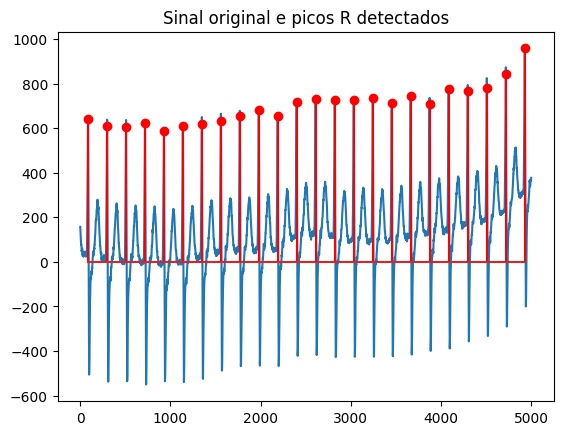

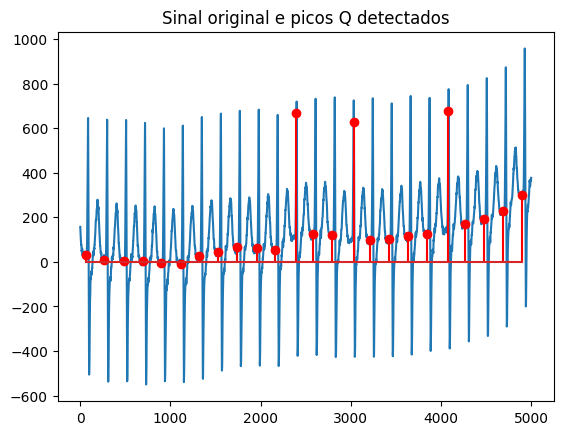

-------------------------------------------
MUSE_20180118_181914_96000


-------------------------------------------
MUSE_20180209_122639_09000


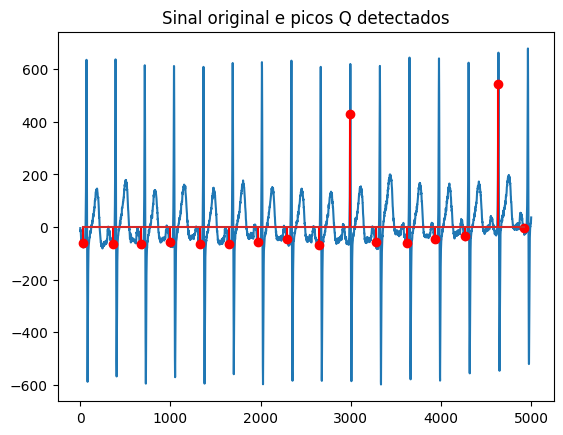

-------------------------------------------
MUSE_20180712_151406_64000


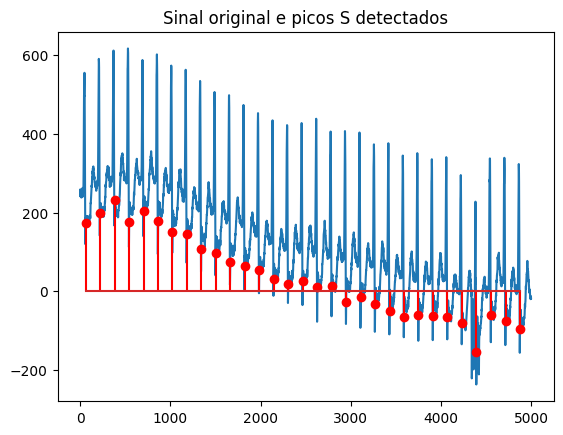

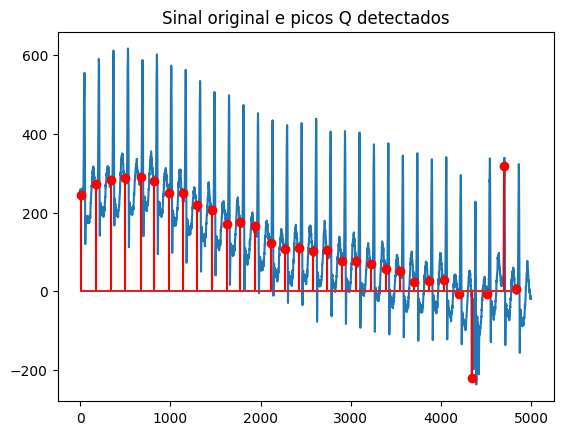

-------------------------------------------
MUSE_20180712_150906_44000


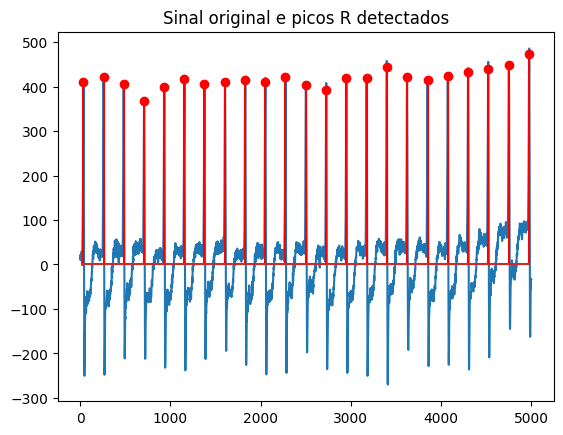

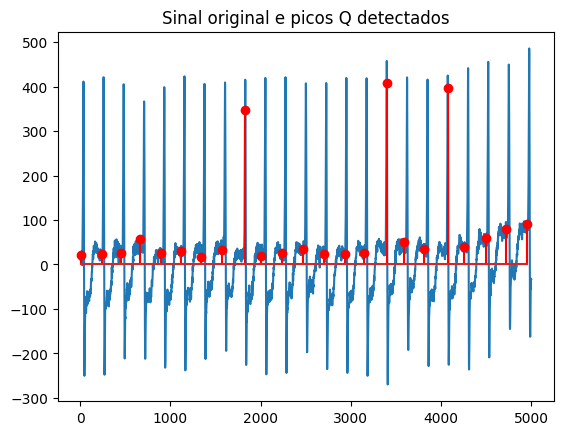

-------------------------------------------
MUSE_20180712_151602_38000


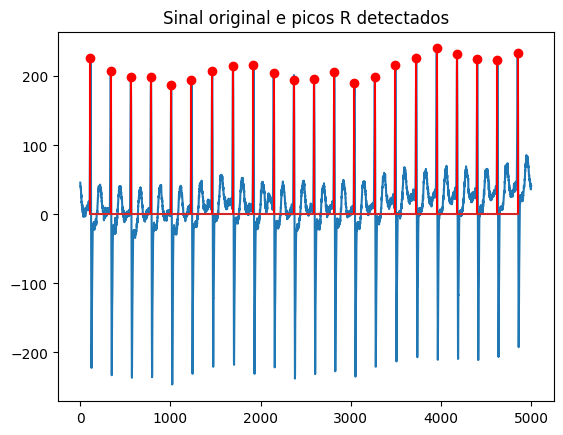

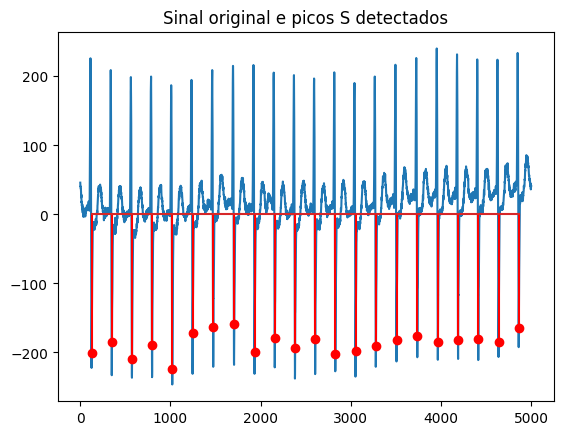

-------------------------------------------
MUSE_20180209_170729_57000


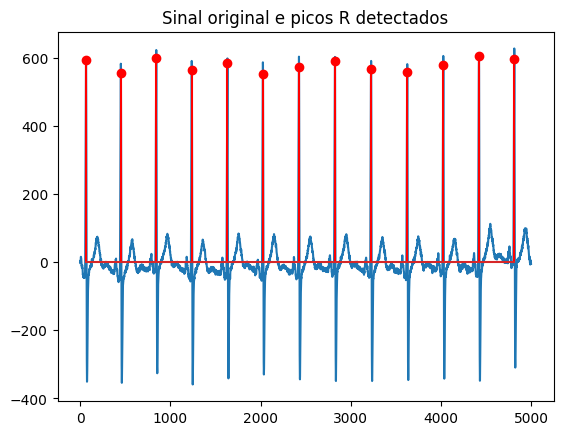

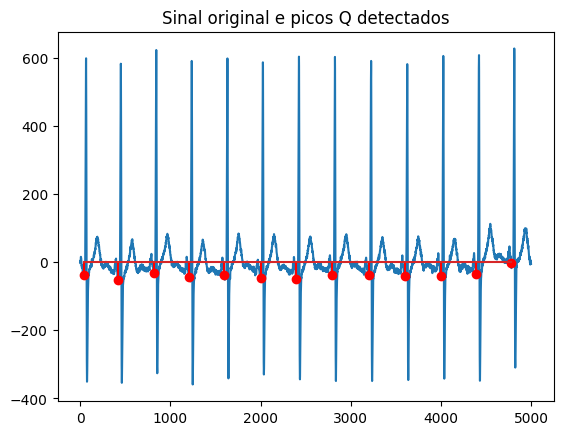

-------------------------------------------
MUSE_20180712_151353_58000


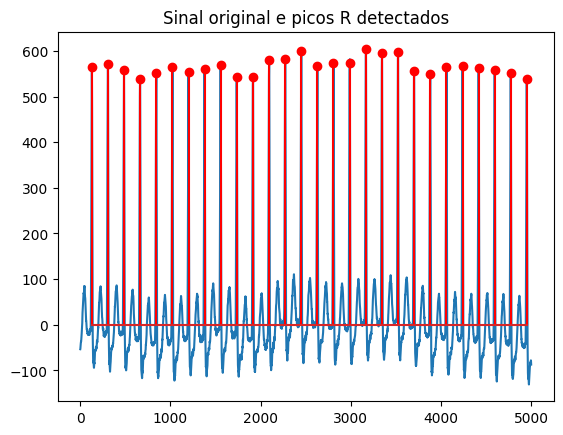

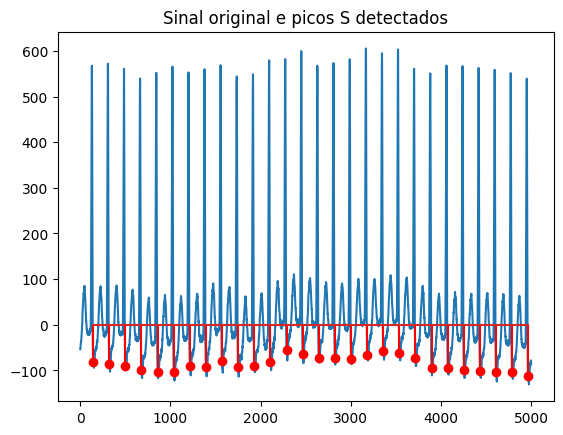

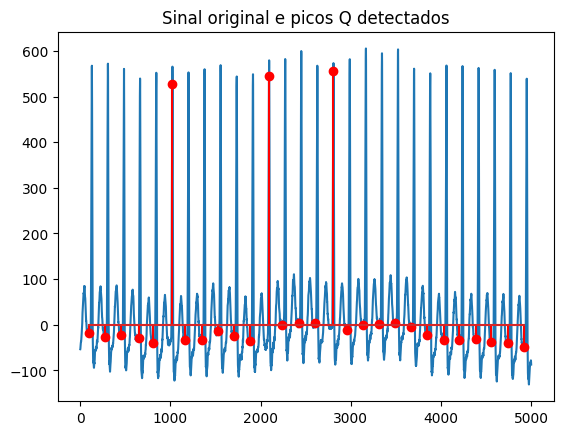

-------------------------------------------
MUSE_20180209_120156_76000


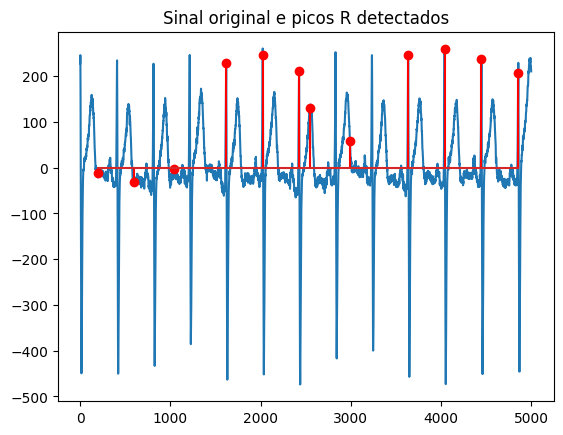

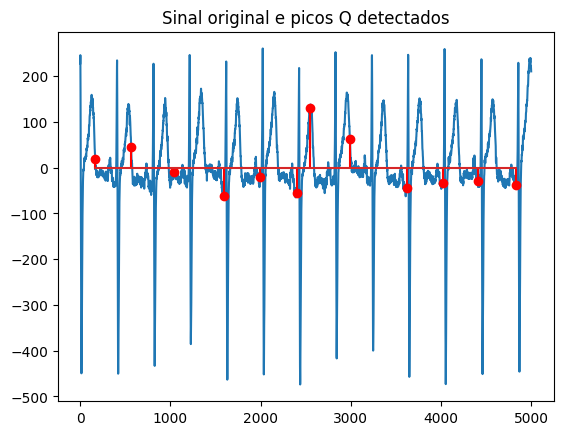

-------------------------------------------
MUSE_20180116_132617_23000


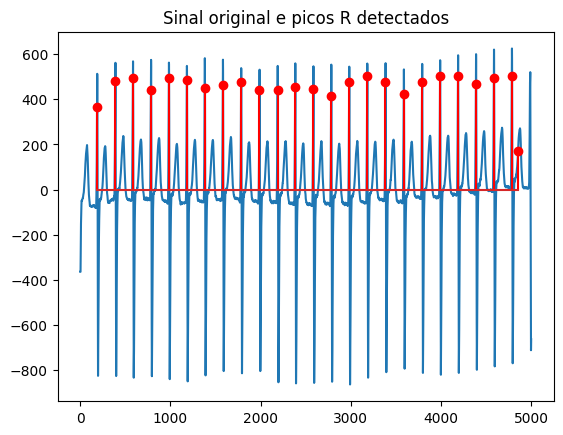

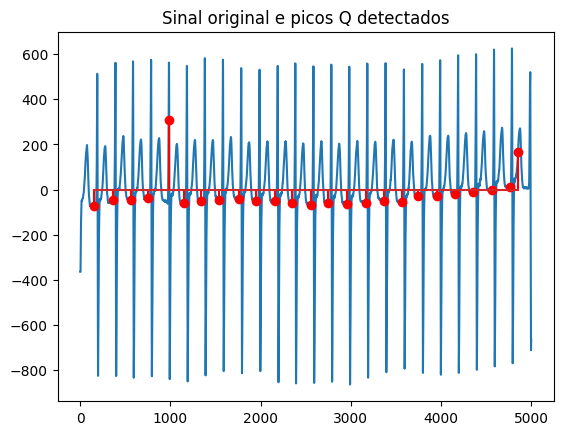

-------------------------------------------


In [21]:
"""
Verificando eficiência da detecção para a soma de todos os sinais das derivações de cada participante
"""
for k in files_name['patient'].sample(10):
    print(k)
    try:
        df = pd.read_csv('ECGData/' + k + '.csv')
        df['all_join'] = (df['I'] + df['II'] + df['III'] + df['aVR'] + df['aVL'] + df['aVF'] + df['V1'] + df['V2'] + df['V3'] + df['V4'] + df['V5'])/12
        x =  df['all_join']
        
        y, k, k2, k3, k4 = deteccao_picos_r(x, type_filter = 'bandpass')
        
        plt.plot(x)
        plt.stem(k2, x[k2], 'r')
        plt.title('Sinal original e picos R detectados')
        plt.show()

        plt.plot(x)
        plt.stem(k3, x[k3], 'r')
        plt.title('Sinal original e picos S detectados')
        plt.show()

        plt.plot(x)
        plt.stem(k4, x[k4], 'r')
        plt.title('Sinal original e picos Q detectados')
        plt.show()

    except Exception as e:
        print(e)
        print('Não')


    print('-------------------------------------------')